In [ ]:
# wersja uproszczona, brak zapisu do s3

In [1]:
import pandas as pd
import os
from pathlib import Path
import re
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

load_dotenv()

True

In [2]:
# wykonaj ipynb dla każdego roku oddzielnie

year = 2024

In [3]:
# wczytanie pliku scv

LOCAL_DATA = Path('data')
file_name = f'halfmarathon_wroclaw_{year}__final.csv'

# Wczytanie danych
df_raw = pd.read_csv(LOCAL_DATA / 'raw' / file_name, sep=";")
print(df_raw.shape)
df_raw.sample(5)

(13007, 27)


,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
12650,NaN,822,ŁUKASZ,WACHOWSKI,NaN,NaN,Sda,M,NaN,M40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNS,NaN
11513,NaN,26523,KATARZYNA,LACH,NaN,NaN,NaN,K,NaN,K40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8936,8937.0,11768,TOMASZ,MATECKI,KAMIENNA GÓRA,POL,FAURECIA,M,6575.0,M30,...,6.646667,01:42:23,9055.0,7.243333,02:19:37,8997.0,7.446667,0.063533,02:27:27,6.989808
883,884.0,52,ALEKSANDER,GRODZICKI,WROCŁAW,POL,BRAK,M,836.0,M20,...,4.546667,01:09:31,1000.0,4.646667,01:33:20,910.0,4.763333,0.005200,01:38:37,4.674883
2807,2808.0,1630,DOMINIK,KRZYWIECKI,WROCŁAW,POL,NaN,M,2515.0,M30,...,5.233333,01:19:32,3348.0,5.386667,01:45:42,2912.0,5.233333,-0.000133,01:51:22,5.279292


In [4]:
# usunięcie kolumn nieistotnych

# Miejsce przyda się do:
# - interpolacji brakujących czasów na 5 km, tu niekoniecznie
# - wyznaczenia miejsca dla czasu predycji

df = df_raw[['Miejsce', 'Płeć', 'Kategoria wiekowa', 'Rocznik', '5 km Czas', 'Czas']]
df['year'] = year
df.sample(5)

/tmp/ipykernel_4352/3350892840.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = year


,Miejsce,Płeć,Kategoria wiekowa,Rocznik,5 km Czas,Czas,year
12903,NaN,M,M30,1988.0,NaN,NaN,2024
7998,7999.0,M,M20,1997.0,00:31:28,02:18:45,2024
625,626.0,M,M40,1982.0,00:22:22,01:35:11,2024
6445,6446.0,K,K20,1996.0,00:30:02,02:08:49,2024
11765,NaN,M,M20,1995.0,NaN,NaN,2024


In [5]:
# Jakie wartości są w kolumnie Czas

def istime(x):
    return (type(x) is str) and (re.search('\d\d\:\d\d\:\d\d', x) != None)

def dist_time(df, col):
    dist = {}
    for x in df[col]:
        if istime(x):
            x = '??:??:??'
        dist[x] = (dist[x] if x in dist else 0) + 1
    return dist

for col in ['5 km Czas', 'Czas']:
    print(f"distinct {col} {dist_time(df, col)}")

distinct 5 km Czas {'??:??:??': 10288, nan: 2719}
distinct Czas {'??:??:??': 10300, nan: 2055, 'DNS': 570, 'DNF': 82}


In [6]:
# Pozostawienie wierszy, które mają poprawny Czas

df = df[df['Czas'].apply(istime)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10300 entries, 0 to 10299
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Miejsce            10300 non-null  float64
 1   Płeć               10300 non-null  object 
 2   Kategoria wiekowa  10289 non-null  object 
 3   Rocznik            10016 non-null  float64
 4   5 km Czas          10288 non-null  object 
 5   Czas               10300 non-null  object 
 6   year               10300 non-null  int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 643.8+ KB


In [7]:
print("Procent pozostałych danych:", round((len(df) / len(df_raw)) * 100, 2), "%")

Procent pozostałych danych: 79.19 %


In [8]:
# Zamieniam kolumny czas na czas w sek

def convert_time_to_seconds(time):
    try:
        h, m, s = map(int, time.split(':'))
        return h * 3600 + m * 60 + s
    except (ValueError, AttributeError):
        return None  

df['5_km_sec'] = df['5 km Czas'].apply(convert_time_to_seconds)
df['finish_sec'] = df['Czas'].apply(convert_time_to_seconds)

df.drop(columns=['5 km Czas', 'Czas'], inplace=True)
df.sample(5)

,Miejsce,Płeć,Kategoria wiekowa,Rocznik,year,5_km_sec,finish_sec
6664,6665.0,K,K20,1996.0,2024,1718.0,7803
5547,5548.0,K,K40,1983.0,2024,1724.0,7444
6869,6870.0,M,M50,1967.0,2024,1834.0,7868
9423,9424.0,M,M30,1990.0,2024,2206.0,9228
3731,3732.0,M,M20,2000.0,2024,1733.0,6955


In [9]:
# sort po Miejsce

# df.sort_values(by='Miejsce', ascending=True, inplace=True)

# być może miejsce odpowiada czasowi, ale czas będzie bardziej wiarygodny
df.sort_values(by='finish_sec', ascending=True, inplace=True)
df.head(5)

,Miejsce,Płeć,Kategoria wiekowa,Rocznik,year,5_km_sec,finish_sec
0,1.0,M,M20,1998.0,2024,906.0,3843
1,2.0,M,M20,1997.0,2024,906.0,3864
2,3.0,M,M20,1998.0,2024,906.0,3880
3,4.0,M,M20,1997.0,2024,947.0,4184
4,5.0,M,M30,1992.0,2024,907.0,4205


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10300 entries, 0 to 10299
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Miejsce            10300 non-null  float64
 1   Płeć               10300 non-null  object 
 2   Kategoria wiekowa  10289 non-null  object 
 3   Rocznik            10016 non-null  float64
 4   year               10300 non-null  int64  
 5   5_km_sec           10288 non-null  float64
 6   finish_sec         10300 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 643.8+ KB


In [11]:
# uzupełnienie kolumny 5_km_sec przez interpolację

df['5_km_sec'].interpolate(method='linear', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10300 entries, 0 to 10299
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Miejsce            10300 non-null  float64
 1   Płeć               10300 non-null  object 
 2   Kategoria wiekowa  10289 non-null  object 
 3   Rocznik            10016 non-null  float64
 4   year               10300 non-null  int64  
 5   5_km_sec           10300 non-null  float64
 6   finish_sec         10300 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 643.8+ KB


In [12]:
df['Rocznik'].isna().sum()

284

In [13]:
import numpy as np

df['Rocznik'].replace(0.0, np.NaN, inplace=True)
df['Rocznik'].isna().sum()

295

In [14]:
# tworzymy kolumnę Wiek

import random

def towiek(row):
    x = row['Rocznik']
    if ~np.isnan(x):
        return row['year'] - x
    else:
        x = row['Kategoria wiekowa']
        if type(x) is str:
            rx = re.search('[K|M](\d)0', x)
            if rx:
                return int(rx.group(1)) * 10 + random.randrange(0, 10)
        return None



df['age'] = df.apply(towiek, axis=1)
#df.groupby(wiek).size()
df['age'].value_counts().sort_index()

age
18.0     16
19.0     53
20.0     78
21.0    111
22.0    141
       ... 
75.0      4
76.0      2
77.0      1
79.0      1
80.0      1
Name: count, Length: 62, dtype: int64

In [15]:
df[df['age'].isna()]

,Miejsce,Płeć,Kategoria wiekowa,Rocznik,year,5_km_sec,finish_sec,age
2279,2280.0,M,NaN,NaN,2024,1566.0,6509,NaN
5592,5593.0,M,NaN,NaN,2024,1641.0,7462,NaN
6011,6012.0,M,NaN,NaN,2024,1664.0,7593,NaN
7138,7139.0,M,NaN,NaN,2024,1926.0,7962,NaN
7716,7717.0,K,NaN,NaN,2024,1921.0,8201,NaN
8869,8870.0,M,NaN,NaN,2024,1988.0,8811,NaN
9360,9361.0,M,NaN,NaN,2024,2002.0,9165,NaN
9703,9704.0,M,NaN,NaN,2024,1948.0,9562,NaN
9829,9831.0,M,NaN,NaN,2024,2106.0,9732,NaN
10036,10039.0,M,NaN,NaN,2024,2083.0,10168,NaN


In [16]:
df['age'].isna().sum()

11

In [17]:
# jeśli nie udało się uzupełnić kolumny Wiek to wiersze odrzucamy

df.dropna(subset=['age'], inplace=True)
df['age'] = df['age'].astype('int32')

print("Procent pozostałych danych:", round((len(df) / len(df_raw)) * 100, 2), "%")

Procent pozostałych danych: 79.1 %


In [18]:
# kolumny Kategoria wiekowa, Rocznik i year usuwamy

df.drop(columns=['Kategoria wiekowa', 'Rocznik', 'year'], inplace=True)
df.sample(10)

,Miejsce,Płeć,5_km_sec,finish_sec,age
3904,3905.0,K,1531.0,6999,55
5105,5106.0,K,1780.0,7291,49
7377,7378.0,M,1690.0,8061,39
7641,7642.0,K,1925.0,8172,46
1108,1109.0,M,1372.0,6023,41
8107,8108.0,K,1762.0,8380,40
7147,7148.0,M,1971.0,7964,39
8130,8131.0,M,1869.0,8391,26
2690,2691.0,M,1561.0,6638,37
2545,2546.0,M,1485.0,6589,40


In [19]:
# zmieniamy Płeć K/M na gender F/M

df['gender'] = df['Płeć'].map({'K': 'F', 'M': 'M'})
df.drop(columns=['Płeć'], inplace=True)

df.sample(5)

,Miejsce,5_km_sec,finish_sec,age,gender
1399,1400.0,1478.0,6177,65,M
3474,3475.0,1531.0,6891,47,M
4377,4378.0,1602.0,7114,46,M
5121,5122.0,1602.0,7296,34,F
2505,2506.0,1479.0,6580,30,M


In [20]:
# Wartości odstających możemy się pozbyć używając np. tzw. IQR (Interquartile Range)
Q1 = df["finish_sec"].quantile(0.25)
Q3 = df["finish_sec"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_nooutliers = df[(df["finish_sec"] >= lower_bound) & (df["finish_sec"] <= upper_bound)]

# Metoda odchylenia standardowego Obliczenie średniej i odchylenia standardowego
# mean = df["finish_sec"].mean()
# std_dev = df["finish_sec"].std()
# stlower_bound = mean - 3 * std_dev
# stupper_bound = mean + 3 * std_dev
# df_nooutliers = df[(df["finish_sec"] >= stlower_bound) & (df["finish_sec"] <= stupper_bound)]


/tmp/ipykernel_4352/771740075.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([timedelta(seconds=int(x.get_text())) for x in ax.get_xticklabels()])


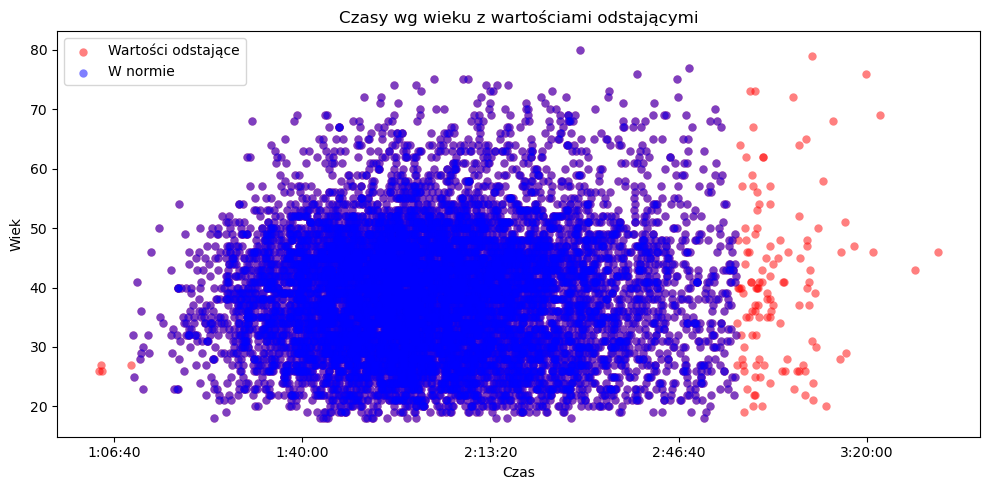

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
# Dane z wartościami odstającymi
sns.scatterplot(data=df, x="finish_sec", y="age", ax=ax, color="red", linewidth=0, alpha=0.5, label="Wartości odstające")
# Dane bez wartości odstających
sns.scatterplot(data=df_nooutliers, x="finish_sec", y="age", ax=ax, color="blue", linewidth=0, alpha=0.5, label="W normie")
# Dodanie tytułu i legendy
ax.set_title("Czasy wg wieku z wartościami odstającymi")
ax.legend()
ax.set_xticklabels([timedelta(seconds=int(x.get_text())) for x in ax.get_xticklabels()])
ax.set_ylabel("Wiek")
ax.set_xlabel("Czas")
plt.tight_layout()
plt.show()

/tmp/ipykernel_4352/1732799827.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([timedelta(seconds=int(x.get_text())) for x in ax.get_xticklabels()])


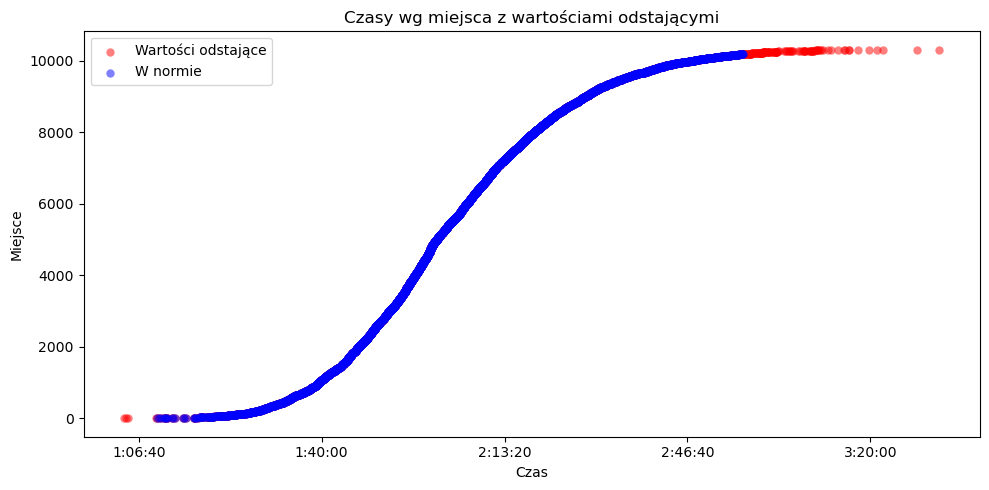

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
# Dane z wartościami odstającymi
sns.scatterplot(data=df, x="finish_sec", y="Miejsce", ax=ax, color="red", linewidth=0, alpha=0.5, label="Wartości odstające")
# Dane bez wartości odstających
sns.scatterplot(data=df_nooutliers, x="finish_sec", y="Miejsce", ax=ax, color="blue", linewidth=0, alpha=0.5, label="W normie")
# Dodanie tytułu i legendy
ax.set_title("Czasy wg miejsca z wartościami odstającymi")
ax.legend()
ax.set_xticklabels([timedelta(seconds=int(x.get_text())) for x in ax.get_xticklabels()])
ax.set_xlabel("Czas")
plt.tight_layout()
plt.show()

In [23]:
#zapisujemy obydwa csv

df.to_csv(LOCAL_DATA / 'current' / os.path.basename(file_name).replace(".csv", "_cleaned_full.csv"), index=False, sep=";")
df_nooutliers.to_csv(LOCAL_DATA / 'current' / os.path.basename(file_name).replace(".csv", "_cleaned.csv"), index=False, sep=";")